<a href="https://colab.research.google.com/github/Hiroyuki-01/gci/blob/main/%E3%82%B3%E3%83%B3%E3%83%9A%EF%BC%92%E3%81%AE%E8%8D%89%E6%A1%88_0701_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Import libraries and datas ライブラリとデータのインポート

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, confusion_matrix

from lightgbm import LGBMClassifier

import warnings
warnings.filterwarnings('ignore')

In [4]:
train = pd.read_csv('/content/drive/MyDrive/gci2021_summer/competition_2/input/train.csv', index_col=0)
test = pd.read_csv('/content/drive/MyDrive/gci2021_summer/competition_2/input/test.csv', index_col=0)

In [ ]:
print(f'Train size: {train.shape}')
print(f'Test size: {test.shape}')

Train size: (171202, 50)
Test size: (61500, 49)


In [ ]:
train.head()

,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,NAME_TYPE_SUITE,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,OWN_CAR_AGE,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,ORGANIZATION_TYPE,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
SK_ID_CURR,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,0,Cash loans,F,N,N,0,112500.0,755190.0,36328.5,675000.0,Unaccompanied,Working,Higher education,Married,House / apartment,0.010032,-9233,-878,-333.0,-522,NaN,1,1,1,1,0,0,Core staff,2.0,2,2,0,1,1,0,1,1,School,NaN,0.372591,NaN,0.0,0.0,0.0,0.0,-292.0,NaN,NaN,NaN,NaN
1,0,Cash loans,F,N,Y,0,225000.0,585000.0,16893.0,585000.0,Unaccompanied,Pensioner,Secondary / secondary special,Married,House / apartment,0.008019,-20148,365243,-4469.0,-3436,NaN,1,0,0,1,0,0,NaN,2.0,2,2,0,0,0,0,0,0,XNA,NaN,0.449567,0.553165,0.0,0.0,0.0,0.0,-617.0,0.0,0.0,0.0,1.0
2,0,Cash loans,F,N,Y,0,54000.0,334152.0,18256.5,270000.0,Family,State servant,Secondary / secondary special,Married,House / apartment,0.004960,-18496,-523,-3640.0,-2050,NaN,1,1,1,1,1,0,Core staff,2.0,2,2,0,0,0,0,0,0,Postal,NaN,0.569503,NaN,4.0,0.0,4.0,0.0,-542.0,NaN,NaN,NaN,NaN
3,0,Cash loans,F,N,Y,0,67500.0,152820.0,8901.0,135000.0,Children,Pensioner,Lower secondary,Widow,House / apartment,0.005002,-24177,365243,-4950.0,-3951,NaN,1,0,0,1,1,0,NaN,1.0,3,3,0,0,0,0,0,0,XNA,NaN,0.105235,0.767523,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,1,Cash loans,M,N,N,0,157500.0,271066.5,21546.0,234000.0,Unaccompanied,Commercial associate,Secondary / secondary special,Married,With parents,0.006296,-10685,-697,-5101.0,-3226,NaN,1,1,1,1,0,0,Drivers,2.0,3,3,0,0,0,0,1,1,Business Entity Type 3,0.342344,0.202490,0.669057,0.0,0.0,0.0,0.0,-1243.0,0.0,0.0,0.0,4.0


In [ ]:
print('TARGET==1: {:.2f}%'.format(train.TARGET.sum()/train.shape[0]*100))

TARGET==1: 8.07%


In [ ]:
train['TARGET'].dtype

dtype('int64')

In [ ]:
categorical_cols = [col for col in train.columns if train[col].dtype=='object']
numerical_cols = [col for col in train.columns if train[col].dtype in ['int64', 'Float64']]
print(f'Length of categorical columns: {len(categorical_cols)}')
print(f'Length of numerical columns: {len(numerical_cols)}')

Length of categorical columns: 11
Length of numerical columns: 39


## Missing values　欠損値の確認


In [ ]:
def show_missing(df):
    missing_list = df.isnull().sum().sort_values(ascending=False) / df.shape[0]
    missing_list = missing_list[missing_list>0]

    plt.subplots(figsize=(12, 6))
    plt.xticks(rotation=90)

    sns.barplot(missing_list.index, missing_list.values)

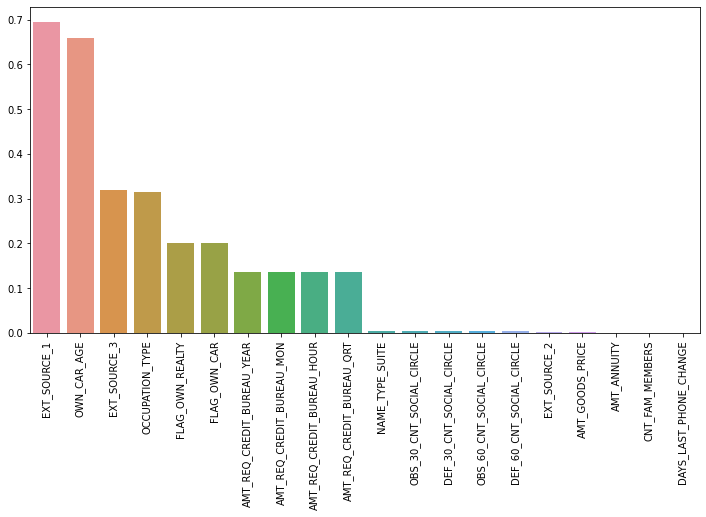

In [ ]:
show_missing(train)

## Correlation matrix   相関行列

In [ ]:
def show_corrmat(df):
    corrmat = df.corr()
    plt.subplots(figsize=(12, 9))
    sns.heatmap(corrmat, vmax=.8, square=True)

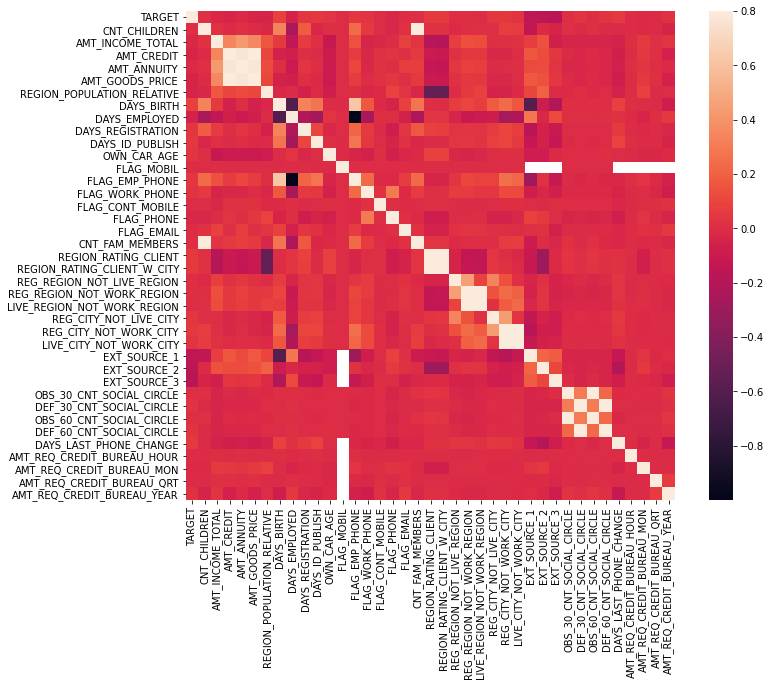

In [ ]:
show_corrmat(train)

### Datas strongly correlated with TARGET
目的変数(Targetカラム)と強く相関するカラムはどれか

In [38]:
k = 12
corr_data = pd.concat([train.corr().nlargest(k, 'TARGET')['TARGET'], train.corr().nsmallest(k, 'TARGET')['TARGET']]).sort_values(ascending=False)
corr_data

TARGET                         1.000000
DAYS_BIRTH                     0.079541
REGION_RATING_CLIENT_W_CITY    0.061132
REGION_RATING_CLIENT           0.058984
DAYS_LAST_PHONE_CHANGE         0.055195
DAYS_ID_PUBLISH                0.052567
REG_CITY_NOT_WORK_CITY         0.049438
FLAG_EMP_PHONE                 0.045646
REG_CITY_NOT_LIVE_CITY         0.043829
DAYS_REGISTRATION              0.041669
OWN_CAR_AGE                    0.040035
DEF_60_CNT_SOCIAL_CIRCLE       0.033064
AMT_REQ_CREDIT_BUREAU_QRT     -0.003098
AMT_REQ_CREDIT_BUREAU_MON     -0.014177
AMT_ANNUITY                   -0.014688
AMT_INCOME_TOTAL              -0.021638
FLAG_PHONE                    -0.021865
AMT_CREDIT                    -0.032727
REGION_POPULATION_RELATIVE    -0.038259
AMT_GOODS_PRICE               -0.041909
DAYS_EMPLOYED                 -0.044592
EXT_SOURCE_1                  -0.154050
EXT_SOURCE_2                  -0.162562
EXT_SOURCE_3                  -0.178317
Name: TARGET, dtype: float64

## Distribution graph
分布グラフ

1.   days_birth
2.   ext_source_3
3.   ext_source_2






In [ ]:
def show_distribution(col):
    plt.subplots(figsize=(8, 4))
    sns.kdeplot(train.loc[train['TARGET'] == 0, col], label='target == 0')
    sns.kdeplot(train.loc[train['TARGET'] == 1, col], label='target == 1')

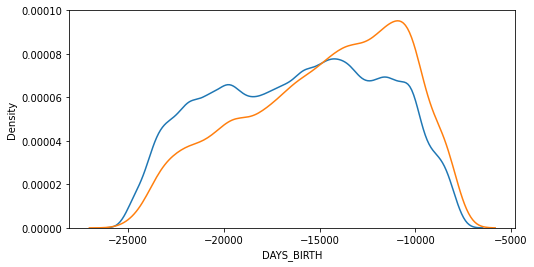

In [ ]:
show_distribution('DAYS_BIRTH')

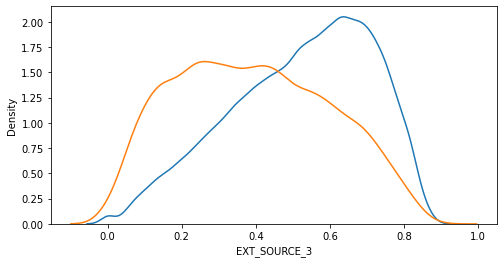

In [ ]:
show_distribution('EXT_SOURCE_3')

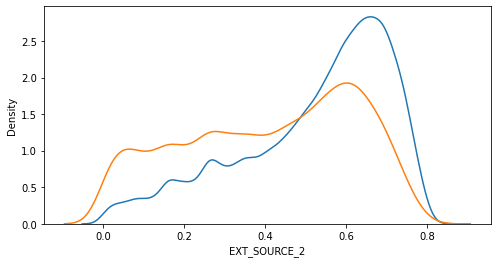

In [ ]:
show_distribution('EXT_SOURCE_2')


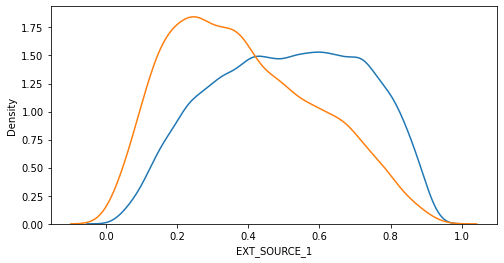

In [ ]:
show_distribution('EXT_SOURCE_1')

In [ ]:
corr_data['EXT_SOURCE_1']

-0.1540495043987891

## Model training
モデル構築

In [32]:
feature_cols = corr_data.index
all_df = pd.concat([train, test]).reset_index(drop=True)[feature_cols]
all_df = pd.concat([train, test])[feature_cols]
all_df

,TARGET,DAYS_BIRTH,REGION_RATING_CLIENT_W_CITY,REGION_RATING_CLIENT,DAYS_LAST_PHONE_CHANGE,DAYS_ID_PUBLISH,REG_CITY_NOT_WORK_CITY,FLAG_EMP_PHONE,REG_CITY_NOT_LIVE_CITY,DAYS_REGISTRATION,OWN_CAR_AGE,AMT_REQ_CREDIT_BUREAU_MON,AMT_ANNUITY,AMT_INCOME_TOTAL,FLAG_PHONE,AMT_CREDIT,REGION_POPULATION_RELATIVE,AMT_GOODS_PRICE,DAYS_EMPLOYED,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3
SK_ID_CURR,,,,,,,,,,,,,,,,,,,,,,
0,0.0,-9233,2,2,-292.0,-522,1,1,0,-333.0,NaN,NaN,36328.5,112500.0,0,755190.0,0.010032,675000.0,-878,NaN,0.372591,NaN
1,0.0,-20148,2,2,-617.0,-3436,0,0,0,-4469.0,NaN,0.0,16893.0,225000.0,0,585000.0,0.008019,585000.0,365243,NaN,0.449567,0.553165
2,0.0,-18496,2,2,-542.0,-2050,0,1,0,-3640.0,NaN,NaN,18256.5,54000.0,1,334152.0,0.004960,270000.0,-523,NaN,0.569503,NaN
3,0.0,-24177,3,3,0.0,-3951,0,0,0,-4950.0,NaN,0.0,8901.0,67500.0,1,152820.0,0.005002,135000.0,365243,NaN,0.105235,0.767523
4,1.0,-10685,3,3,-1243.0,-3226,1,1,0,-5101.0,NaN,0.0,21546.0,157500.0,0,271066.5,0.006296,234000.0,-697,0.342344,0.202490,0.669057
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
232697,NaN,-11430,2,2,-1.0,-2705,0,1,0,-9772.0,12.0,1.0,37800.0,315000.0,0,1288350.0,0.007020,1125000.0,-792,0.263678,0.018172,0.307737
232698,NaN,-17181,2,2,-2732.0,-668,1,1,1,-5125.0,NaN,0.0,15408.0,90000.0,0,273636.0,0.006671,247500.0,-839,NaN,0.668578,0.434733
232699,NaN,-14515,2,2,-615.0,-4795,0,1,0,-7225.0,NaN,0.0,26725.5,144000.0,0,291384.0,0.018801,270000.0,-722,0.510226,0.574151,NaN


In [33]:
all_df = all_df.fillna(all_df.mean())

In [55]:
def to_add_feature(df):
  df['EXT_123_mean'] = (df['EXT_SOURCE_1'] + df['EXT_SOURCE_2'] + df['EXT_SOURCE_3']) / 3
  df['EXT_23_mean'] = (df['EXT_SOURCE_2'] + df['EXT_SOURCE_3']) / 2
  df['EXT_12_mean'] = (df['EXT_SOURCE_1'] + df['EXT_SOURCE_2']) / 2
  df['EXT_13_mean'] = (df['EXT_SOURCE_1'] + df['EXT_SOURCE_3']) / 2
  
  df['CREDIT_ANNUITY'] = df['AMT_ANNUITY'] / df['AMT_CREDIT']
  df['CREDIT_GOODS_PRICE'] = df['AMT_CREDIT'] / df['AMT_GOODS_PRICE']
  df['INCOME_TOTAL_ANNUITY'] = df['AMT_ANNUITY'] / df['AMT_INCOME_TOTAL']
  df['INCOME_TOTAL_CREDIT'] = df['AMT_INCOME_TOTAL'] / df['AMT_CREDIT']
  
to_add_feature(all_df)

In [56]:
X = all_df[:train.shape[0]].drop(['TARGET'], axis=1)

y = all_df[:train.shape[0]]['TARGET']
X_test = all_df[train.shape[0]:].drop(['TARGET'], axis=1)


In [57]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.25)

def show_hist(pred):
    plt.figure(figsize=(8,4))
    plt.hist(pred[np.where(y_valid == 0)], bins=100, alpha=0.75, label='neg class')
    plt.hist(pred[np.where(y_valid == 1)], bins=100, alpha=0.75, label='pos class')
    plt.legend()
    plt.show()

AUC: 0.743548909370941


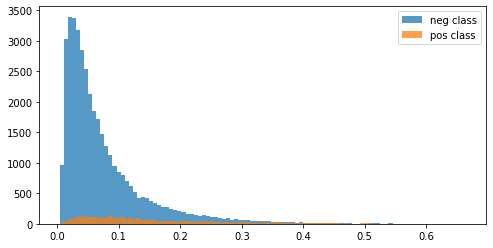

In [58]:
model = LGBMClassifier()
model.fit(X_train, y_train)
    
y_pred = model.predict_proba(X_valid)[:, 1]
score = roc_auc_score(y_valid, y_pred)
    
print(f'AUC: {score}')
show_hist(y_pred)

## Submit prediction

In [44]:
submission_path='/content/drive/MyDrive/Colab Notebooks/competition_2_note/submission.csv'
submission = pd.read_csv(submission_path)
result = model.predict_proba(X_test)[:, 1]


In [47]:
submission=submission.drop(columns=(submission.columns[0]))

In [48]:
submission['TARGET']=result

In [49]:
submission

,SK_ID_CURR,TARGET
0,171202,0.050977
1,171203,0.155928
2,171204,0.195551
3,171205,0.184724
4,171206,0.250510
...,...,...
61495,232697,0.256662
61496,232698,0.067350
61497,232699,0.066891
61498,232700,0.268951


In [ ]:
#submission=submission.drop(columns=submission.columns[[0,1,2]])

In [50]:
submission_path='/content/drive/MyDrive/Colab Notebooks/competition_2_note/submission0701-1330.csv'
submission.to_csv(submission_path)